# Task:
Q1. Perform image classification using CNN on the MNIST dataset. Follow the standard train
and test split. Design an 8-layer CNN network (choose your architecture, e.g., filter size, number
of channels, padding, activations, etc.). Perform the following tasks:
1. Show the calculation of output filter size at each layer of CNN.
2. Calculate the number of parameters in your CNN. Calculation steps should be clearly
shown in the report.
3. Report the following on test data: (should be implemented from scratch)
a. Confusion matrix
b. Overall and classwise accuracy.
c. ROC curve. (you can choose one class as positive and the rest classes as
negative)

4. Report loss curve during training.
5. Replace your CNN with resnet18 and compare it with all metrics given in part 3.
Comment on the final performance of your CNN and resnet18.

## Imports

In [1]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary
import torch.nn.functional as F

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torch.optim as optim

In [4]:
from tqdm import tqdm_notebook as tqdm

In [5]:
from sklearn.metrics import roc_auc_score

## Loading dataset and pre-processing

In [6]:
mnist = fetch_openml('mnist_784', as_frame=False, cache=False)
print("shape of dataset: ",mnist.data.shape)

X = mnist.data.astype('float32')
y = mnist.target.astype('int64')

X /= 255.0

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


shape of dataset:  (70000, 784)


In [7]:
print("length of train: ", len(X_train))
print("length of test: ", len(X_test))

length of train:  56000
length of test:  14000


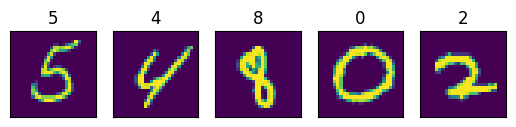

In [8]:
for i in range(5):
  img = X_train[i].reshape(28, 28)
  #plt.figure( figsize=(10,10))
  plt.subplot(151+i)
  plt.imshow( img)
  plt.title( y_train[i])
  plt.xticks([])
  plt.yticks([])


## Building a convolutional neural network

### Preparing data for NN

In [9]:
X_train_np = np.asarray(X_train)
X_test_np = np.asarray(X_test)
y_train_np = np.asarray(y_train)
y_test_np = np.asarray(y_test)

# print( X_train_np.shape)
# print( y_train_np.shape)

X_train_np = X_train_np.reshape( X_train_np.shape[0], 28, 28, 1)
X_test_np = X_test_np.reshape( X_test_np.shape[0], 28, 28, 1)

print( X_train_np.shape)
print( y_train_np.shape)

(56000, 28, 28, 1)
(56000,)


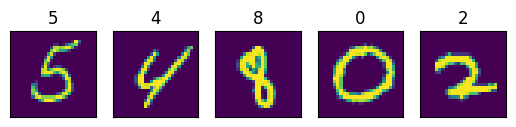

In [10]:
for i in range(5):
  img = X_train_np[i].reshape(28, 28)
  #plt.figure( figsize=(10,10))
  plt.subplot(151+i)
  plt.imshow( img)
  plt.title( y_train_np[i])
  plt.xticks([])
  plt.yticks([])


In [11]:
X_train_np = np.swapaxes( X_train_np, 1, 3)
X_train_np = np.swapaxes( X_train_np, 2, 3)
X_test_np = np.swapaxes( X_test_np, 1, 3)
X_test_np = np.swapaxes( X_test_np, 2, 3)

print("shape for our train data: ", X_train_np.shape)
print("shape for our test data: ", X_test_np.shape)


shape for our train data:  (56000, 1, 28, 28)
shape for our test data:  (14000, 1, 28, 28)


In [12]:
class Dataset(Dataset):
    def __init__(self, X,y, transform=None):
        #super().__init__()
        self.X = torch.from_numpy(X).float()
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.y)

    def __getitem__(self, index):
        image= self.X[index]
        label =self.y[index]
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [13]:
dataset_train = Dataset(X=X_train_np, y=y_train_np , transform=None)
dataset_valid = Dataset(X=X_test_np, y=y_test_np   , transform=None)
batch_size = 128

train_loader = DataLoader(dataset = dataset_train, batch_size=batch_size, shuffle=True, num_workers=0)
valid_loader = DataLoader(dataset = dataset_valid, batch_size=batch_size//2, shuffle=False, num_workers=0)

In [14]:
for image, label in valid_loader:
  print(image[0].shape, label[0])
  break

torch.Size([1, 28, 28]) tensor(8)


### CNN Architecture

In [15]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=7), # 22
            nn.ReLU(),
            )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(4, 8, kernel_size=5), # 18
            nn.ReLU()
            )

        self.layer3 = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=5), # 14
            nn.ReLU()
            )
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5), # 10
            nn.ReLU()
            )
        
        self.layer5 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3), # 8
            nn.ReLU()
        )

        self.layer6 = nn.Sequential(
            nn.Conv2d(64, 96, kernel_size=3), # 6
            nn.ReLU()
        )

        self.layer7 = nn.Sequential(
            nn.Conv2d(96, 96, kernel_size=3), # 4
            nn.ReLU()
        )


        self.layer8 = nn.Sequential(
            nn.Conv2d(96, 128, kernel_size=3), # 2
            nn.ReLU(),
            nn.MaxPool2d(2)

        )

        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, 10)



    def forward(self,x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer7(x)
        x = self.layer8(x)
        x = x.view(-1, 128)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 15
num_classes = 10
learning_rate = 0.0003

valid_size = 0.1

In [17]:
device

device(type='cuda')

In [18]:
model = CNN().to(device)
summary(model, input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 22, 22]             200
              ReLU-2            [-1, 4, 22, 22]               0
            Conv2d-3            [-1, 8, 18, 18]             808
              ReLU-4            [-1, 8, 18, 18]               0
            Conv2d-5           [-1, 16, 14, 14]           3,216
              ReLU-6           [-1, 16, 14, 14]               0
            Conv2d-7           [-1, 32, 10, 10]          12,832
              ReLU-8           [-1, 32, 10, 10]               0
            Conv2d-9             [-1, 64, 8, 8]          18,496
             ReLU-10             [-1, 64, 8, 8]               0
           Conv2d-11             [-1, 96, 6, 6]          55,392
             ReLU-12             [-1, 96, 6, 6]               0
           Conv2d-13             [-1, 96, 4, 4]          83,040
             ReLU-14             [-1, 9

In [24]:
print(model)

CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 4, kernel_size=(7, 7), stride=(1, 1))
    (1): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(4, 8, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
  )
  (layer3): Sequential(
    (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
  )
  (layer5): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
  )
  (layer6): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
  )
  (layer7): Sequential(
    (0): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
  )
  (layer8): Sequential(
    (0): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc2): Linear(in_features=64

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)


### Training

In [20]:
training_loss = []
val_loss = []
min_loss = np.float('inf')

for epoch in range(num_epochs):
  running_train_loss = 0.0
  running_val_loss = 0.0

  model.train()
  for image, label in train_loader:
    image = image.to(device)
    label = label.to(device)

    output = model(image)
    loss = criterion(output, label)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_train_loss += loss.item()

  model.eval()
  for image, label in valid_loader:
    image = image.to(device)
    label = label.to(device)

    output = model(image)
    loss = criterion(output, label)
    running_val_loss +=loss.item()


  print(f"Training Loss @{epoch+1} epoch = {running_train_loss/len(train_loader)}")
  training_loss.append( running_train_loss/len(train_loader))
  val_loss.append( running_val_loss/len(valid_loader))

  current_val_loss = running_val_loss/len(valid_loader)
  # print(min_loss, current_val_loss)
  if min_loss >= current_val_loss :
    torch.save(model.state_dict(), 'best_model.pt')
    min_loss = current_val_loss


Training Loss @1 epoch = 0.9707941495936755
Training Loss @2 epoch = 0.355788730527168
Training Loss @3 epoch = 0.24404374960826958
Training Loss @4 epoch = 0.19779784058871336
Training Loss @5 epoch = 0.17175117545850474
Training Loss @6 epoch = 0.14815378273288682
Training Loss @7 epoch = 0.128903719660354
Training Loss @8 epoch = 0.11788106446056605
Training Loss @9 epoch = 0.10677703997315881
Training Loss @10 epoch = 0.09518120732566673
Training Loss @11 epoch = 0.0913731542768884
Training Loss @12 epoch = 0.08366169298246298
Training Loss @13 epoch = 0.07949018778840769
Training Loss @14 epoch = 0.07465730860540176
Training Loss @15 epoch = 0.06805143632062766


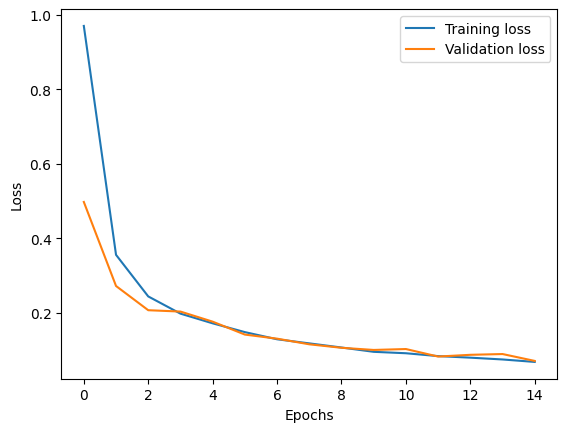

In [22]:

plt.plot(training_loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


### Predicition and evaluation

In [27]:
ground_truth = None
predictions = None
init_flag = True
probas = None

model = CNN()
model.load_state_dict( torch.load("best_model.pt"))
model.to(device)
model.eval()

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        if init_flag:
          init_flag = False
          ground_truth = labels
          predictions = predicted
          probas = outputs

        else:
          ground_truth = torch.cat( (ground_truth, labels), dim=-1)
          predictions = torch.cat( (predictions, predicted), dim=-1)
          probas = torch.cat( (probas, outputs), dim=0)
          
    print('Test Accuracy of the model on the test images: {} %'.format(100 * correct / total))


Test Accuracy of the model on the test images: 97.65714285714286 %


In [28]:
def confusion_matrix(true_labels, predicted_labels):
    num_classes = 10
    conf_matrix = [[0] * num_classes for _ in range(num_classes)]

    # fill in the confusion matrix
    for true, pred in zip(true_labels, predicted_labels):
        conf_matrix[true][pred] += 1

    return conf_matrix

In [29]:
def classwise_accuracy(true_labels, predicted_labels):
    num_classes = 10
    overall_correct = 0
    class_correct = [0] * num_classes
    class_total = [0] * num_classes

    for true, pred in zip(true_labels, predicted_labels):
        if true == pred:
            overall_correct += 1
            class_correct[true] += 1
        class_total[true] += 1

    overall_accuracy = overall_correct / len(true_labels)
    classwise_accuracies = [class_correct[i] / class_total[i] for i in range(num_classes)]

    return overall_accuracy, classwise_accuracies

In [30]:
'''
reference: https://towardsdatascience.com/roc-curve-and-auc-from-scratch-in-numpy-visualized-2612bb9459ab
'''
def plot_roc_curve(y_true, y_proba, truth):
    order = np.argsort(y_proba)[::-1]
    y_true = y_true[order]
    y_proba = y_proba[order]

    tp = np.cumsum(y_true == 1)
    fp = np.cumsum(y_true == 0)

    tpr = tp / tp[-1]
    fpr = fp / fp[-1]

    auc = np.trapz(tpr, fpr)

    plt.figure( figsize=(3,3))
    plt.plot(fpr, tpr, label=f"AUC-ROC = {auc:.3f}")
    plt.xlabel("FPR", fontsize=10)
    plt.ylabel("TPR", fontsize=10)
    plt.title(f"ROC Curve with {truth} as positive label", fontsize=10)
    plt.legend()
    plt.show()


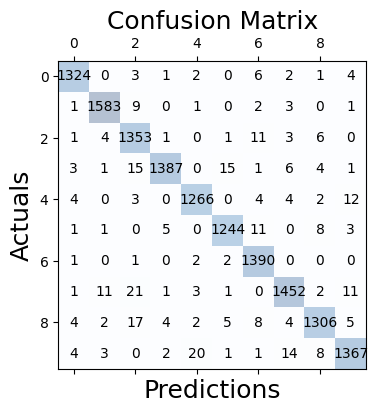

In [33]:
'''
reference for plotting: https://vitalflux.com/python-draw-confusion-matrix-matplotlib/
'''

confusion = confusion_matrix( ground_truth, predictions)
confusion = np.array(confusion)

fig, ax = plt.subplots(figsize=(4, 4))
ax.matshow(confusion, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confusion.shape[0]):
    for j in range(confusion.shape[1]):
        ax.text(x=j, y=i,s=confusion[i, j], va='center', ha='center', size='medium')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [34]:
acc, class_acc = classwise_accuracy(ground_truth, predictions)
print("Overall Accuracy :", round(acc, 4))
for i in range(10):
  print(f"Accuracy of {i} : {round(class_acc[i], 3 )}")

Overall Accuracy : 0.9766
Accuracy of 0 : 0.986
Accuracy of 1 : 0.989
Accuracy of 2 : 0.98
Accuracy of 3 : 0.968
Accuracy of 4 : 0.978
Accuracy of 5 : 0.977
Accuracy of 6 : 0.996
Accuracy of 7 : 0.966
Accuracy of 8 : 0.962
Accuracy of 9 : 0.963


In [35]:
gt_ = ground_truth.cpu().numpy()
pred_ = predictions.cpu().numpy()
probas_ = probas.cpu().numpy()


In [36]:
pred_3 = []
for row in probas_:
  e_x = np.exp( row )
  e_x = e_x / np.sum( e_x)
  pred_3.append( round(e_x[3],3))

pred_3 = np.array( pred_3)
gt_3 =np.where( gt_==3,1,0)

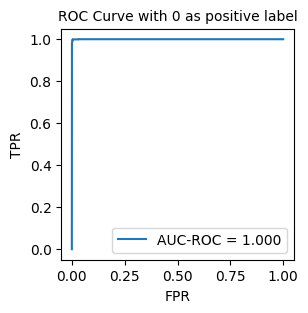

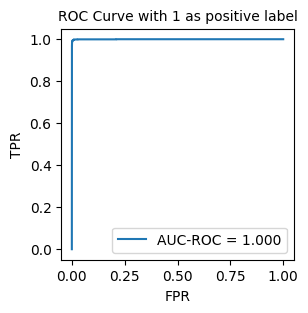

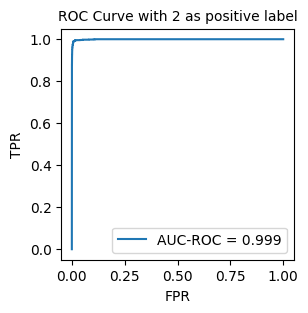

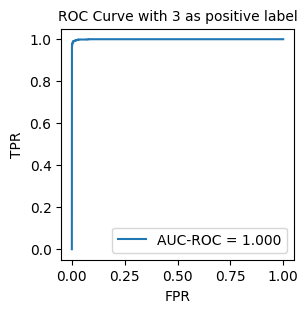

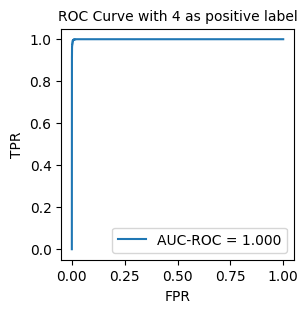

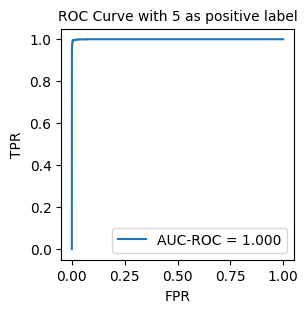

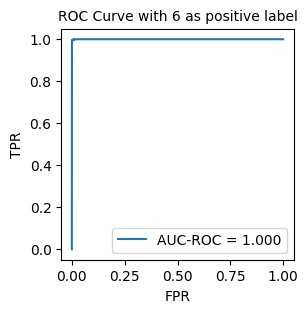

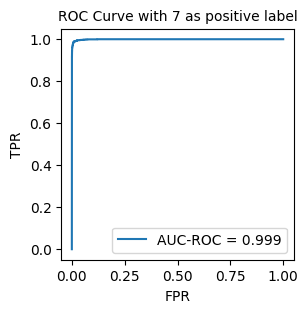

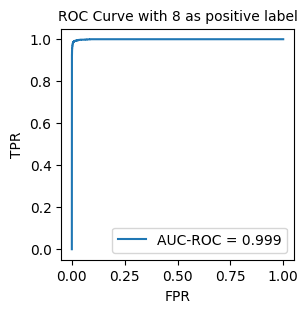

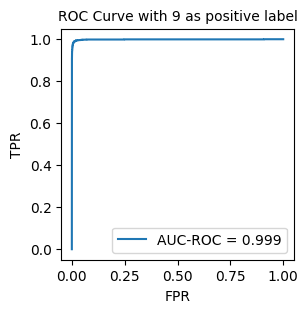

In [37]:
for i in range(10):
  pred_i = []
  for row in probas_:
    e_x = np.exp( row )
    e_x = e_x / np.sum( e_x)
    pred_i.append( round(e_x[i],3))

  pred_i = np.array( pred_i)
  gt_i = np.where( gt_==i,1,0)

  plot_roc_curve( gt_i, pred_i, i)

## Resnet18

### Model load

In [33]:
import torch.optim as optim
import torchvision.models as models

resnet = models.resnet18(pretrained=False)
resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

### Model train

In [31]:

resnet.fc = nn.Linear(resnet.fc.in_features, 10)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)

num_epochs = 10
for epoch in range(num_epochs):
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = resnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Save the model
torch.save(resnet.state_dict(), 'resnet18_model.pth')


Epoch [1/10], Loss: 0.1373
Epoch [2/10], Loss: 0.0151
Epoch [3/10], Loss: 0.0659
Epoch [4/10], Loss: 0.0281
Epoch [5/10], Loss: 0.0417
Epoch [6/10], Loss: 0.0030
Epoch [7/10], Loss: 0.0079
Epoch [8/10], Loss: 0.0040
Epoch [9/10], Loss: 0.0022
Epoch [10/10], Loss: 0.0032


: 

### Eval

In [36]:
ground_truth = None
predictions = None
init_flag = True
probas = None

model = models.resnet18(pretrained=False)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.fc = nn.Linear(model.fc.in_features, 10)
model.load_state_dict( torch.load("resnet18_model.pth"))
model.to(device)
model.eval()

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        if init_flag:
          init_flag = False
          ground_truth = labels
          predictions = predicted
          probas = outputs

        else:
          ground_truth = torch.cat( (ground_truth, labels), dim=-1)
          predictions = torch.cat( (predictions, predicted), dim=-1)
          probas = torch.cat( (probas, outputs), dim=0)
          
    print('Test Accuracy of the model on the test images: {} %'.format(100 * correct / total))


Test Accuracy of the model on the test images: 98.36428571428571 %


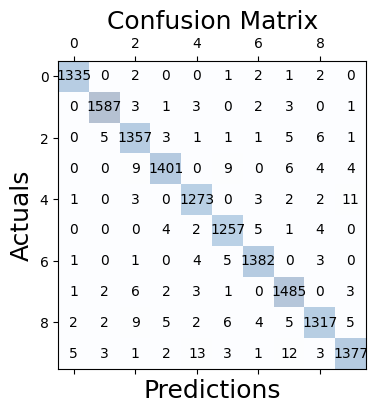

In [37]:
confusion = confusion_matrix( ground_truth, predictions)
confusion = np.array(confusion)

fig, ax = plt.subplots(figsize=(4, 4))
ax.matshow(confusion, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confusion.shape[0]):
    for j in range(confusion.shape[1]):
        ax.text(x=j, y=i,s=confusion[i, j], va='center', ha='center', size='medium')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [38]:
acc, class_acc = classwise_accuracy(ground_truth, predictions)
print("Overall Accuracy :", round(acc, 4))
for i in range(10):
  print(f"Accuracy of {i} : {round(class_acc[i], 3 )}")

Overall Accuracy : 0.9836
Accuracy of 0 : 0.994
Accuracy of 1 : 0.992
Accuracy of 2 : 0.983
Accuracy of 3 : 0.978
Accuracy of 4 : 0.983
Accuracy of 5 : 0.987
Accuracy of 6 : 0.99
Accuracy of 7 : 0.988
Accuracy of 8 : 0.971
Accuracy of 9 : 0.97


In [39]:
gt_ = ground_truth.cpu().numpy()
pred_ = predictions.cpu().numpy()
probas_ = probas.cpu().numpy()


In [40]:
pred_3 = []
for row in probas_:
  e_x = np.exp( row )
  e_x = e_x / np.sum( e_x)
  pred_3.append( round(e_x[3],3))

pred_3 = np.array( pred_3)
gt_3 =np.where( gt_==3,1,0)

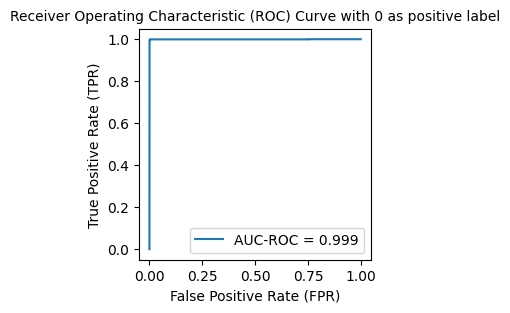

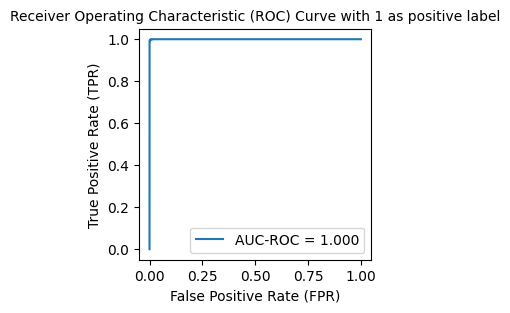

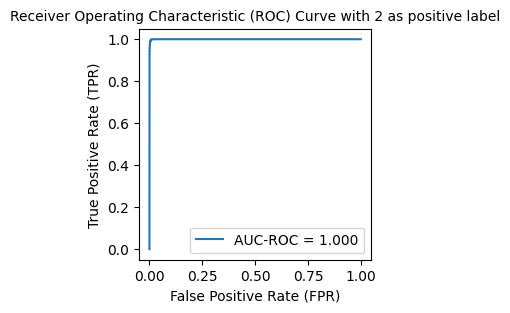

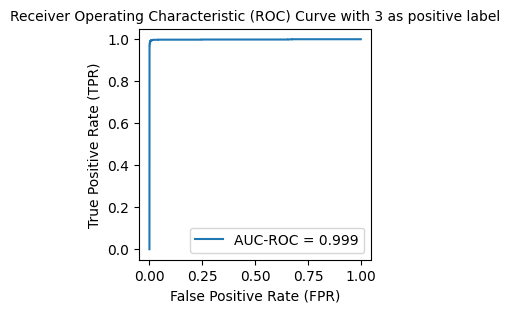

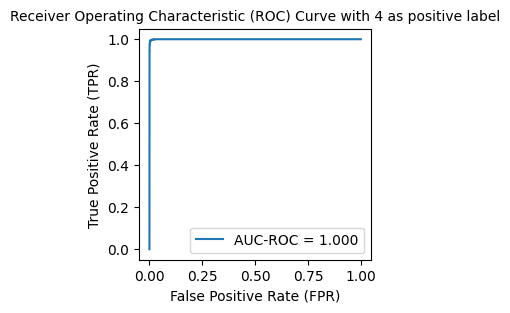

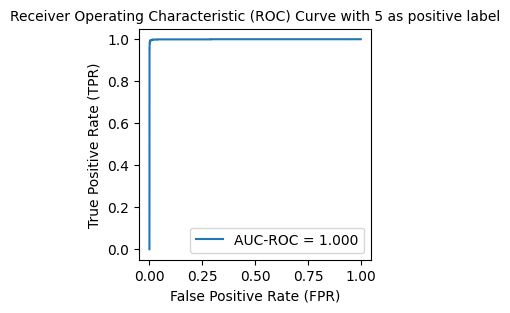

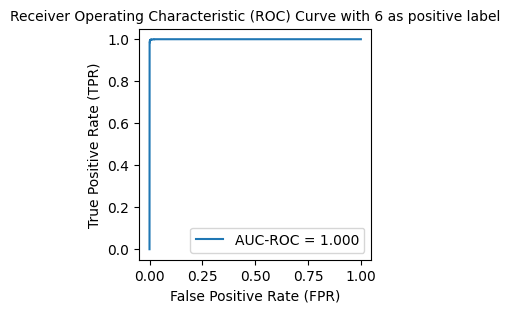

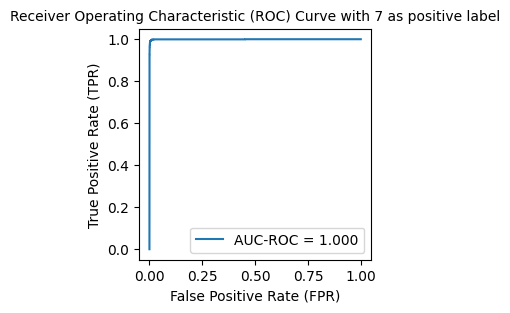

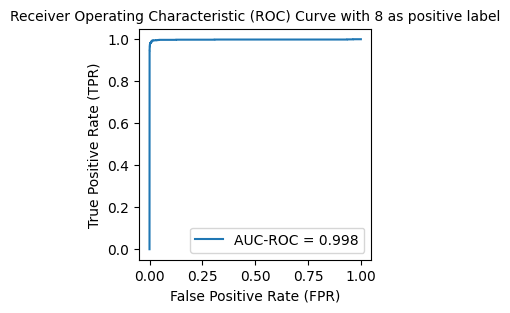

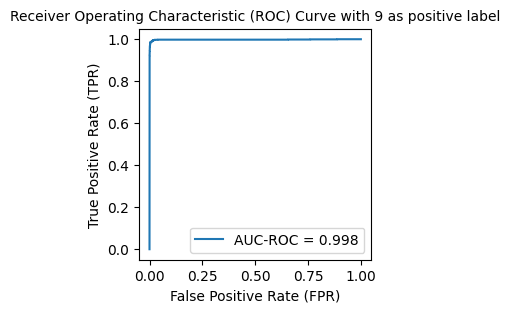

In [41]:
for i in range(10):
  pred_i = []
  for row in probas_:
    e_x = np.exp( row )
    e_x = e_x / np.sum( e_x)
    pred_i.append( round(e_x[i],3))

  pred_i = np.array( pred_i)
  gt_i = np.where( gt_==i,1,0)

  plot_roc_curve( gt_i, pred_i, i)